<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S8_Master_Model_ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
! ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/project_folder
Untitled0.ipynb


In [0]:
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1

Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 808, done.
remote: Total 808 (delta 0), reused 0 (delta 0), pack-reused 808
Receiving objects: 100% (808/808), 4.37 MiB | 2.85 MiB/s, done.
Resolving deltas: 100% (508/508), done.


In [0]:
%cd Deep_Learning_EVA4_Phase1/S8_ResNet_Improved_Modular
! ls

/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S8_ResNet_Improved_Modular
model  README.md


In [0]:
#!pip install torchviz

In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm,tqdm_notebook
#from torchviz import make_dot
from model import Datatransforms,Model,Dataloaders,Train_Losses,Test_losses

In [0]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

No: Of Train Images: 50000 
Channels Mean: [0.49139968 0.48215841 0.44653091] 
Channels Stdev: [0.24703223 0.24348513 0.26158784] 
Channels squared sum mean: [0.30249857 0.29176174 0.26781806] 
Total Pixles (N): 51200000


In [0]:
data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image

transform_instance  = Datatransforms.Transforms_custom(normalize=True, mean=channels_mean, stdev=channels_stdev)

before_norm_list = [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                    transforms.RandomRotation((-15,15),fill=tuple(fillmeans)),
                    transforms.RandomHorizontalFlip()]
after_norm_list  = [transforms.RandomErasing(value = channels_mean)]  # Will fill the erased area with channels_mean pixels                   
               
test_transforms   = transform_instance.test_transforms()
train_transforms  = transform_instance.train_transforms(before_norm=before_norm_list, after_norm=after_norm_list)

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model.ResNet18()
model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

# Train and Test the model 

In [0]:
EPOCH     = 30
L2_factor = 0.0001
L1_factor = 0.0005
OPTIMIZER = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=L2_factor)
train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []

for epoch in range(EPOCH):

    print("EPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,device,train_loader=trainloader,optimizer=OPTIMIZER,epoch=EPOCH,factor=L1_factor)
    test_losses, test_acc   = test_loss.test_loss_calc(model,device,test_loader=testloader)

    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Train Loss = 1.4563242197036743 Batch Id = 390 Train Accuracy = 41.76: 100%|██████████| 391/391 [03:19<00:00,  2.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2512, Test Accuracy: 55.67

EPOCH: 1


Train Loss = 0.9040476083755493 Batch Id = 390 Train Accuracy = 59.15: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8725, Test Accuracy: 70.15

EPOCH: 2


Train Loss = 0.8899436593055725 Batch Id = 390 Train Accuracy = 67.38: 100%|██████████| 391/391 [03:19<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7524, Test Accuracy: 73.87

EPOCH: 3


Train Loss = 0.8435320854187012 Batch Id = 390 Train Accuracy = 71.50: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6696, Test Accuracy: 76.92

EPOCH: 4


Train Loss = 0.5636163353919983 Batch Id = 390 Train Accuracy = 74.85: 100%|██████████| 391/391 [03:19<00:00,  2.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6437, Test Accuracy: 77.57

EPOCH: 5


Train Loss = 0.6323872804641724 Batch Id = 390 Train Accuracy = 76.53: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5556, Test Accuracy: 80.98

EPOCH: 6


Train Loss = 0.5545644760131836 Batch Id = 390 Train Accuracy = 78.51: 100%|██████████| 391/391 [03:19<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4749, Test Accuracy: 83.41

EPOCH: 7


Train Loss = 0.6009019017219543 Batch Id = 390 Train Accuracy = 79.85: 100%|██████████| 391/391 [03:19<00:00,  2.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4923, Test Accuracy: 83.55

EPOCH: 8


Train Loss = 0.42283740639686584 Batch Id = 390 Train Accuracy = 80.97: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4716, Test Accuracy: 83.65

EPOCH: 9


Train Loss = 0.5925178527832031 Batch Id = 390 Train Accuracy = 82.16: 100%|██████████| 391/391 [03:18<00:00,  2.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4465, Test Accuracy: 84.58

EPOCH: 10


Train Loss = 0.5668609738349915 Batch Id = 390 Train Accuracy = 82.89: 100%|██████████| 391/391 [03:18<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4398, Test Accuracy: 85.29

EPOCH: 11


Train Loss = 0.49456921219825745 Batch Id = 390 Train Accuracy = 83.95: 100%|██████████| 391/391 [03:18<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4575, Test Accuracy: 84.54

EPOCH: 12


Train Loss = 0.464686781167984 Batch Id = 390 Train Accuracy = 84.78: 100%|██████████| 391/391 [03:18<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4867, Test Accuracy: 83.73

EPOCH: 13


Train Loss = 0.4316105246543884 Batch Id = 390 Train Accuracy = 85.41: 100%|██████████| 391/391 [03:18<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3781, Test Accuracy: 87.26

EPOCH: 14


Train Loss = 0.3846023976802826 Batch Id = 390 Train Accuracy = 85.88: 100%|██████████| 391/391 [03:18<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3974, Test Accuracy: 87.20

EPOCH: 15


Train Loss = 0.3499668538570404 Batch Id = 390 Train Accuracy = 86.48: 100%|██████████| 391/391 [03:18<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4280, Test Accuracy: 85.88

EPOCH: 16


Train Loss = 0.40727418661117554 Batch Id = 390 Train Accuracy = 86.89: 100%|██████████| 391/391 [03:19<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3965, Test Accuracy: 87.10

EPOCH: 17


Train Loss = 0.4560825228691101 Batch Id = 390 Train Accuracy = 87.55: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3619, Test Accuracy: 87.97

EPOCH: 18


Train Loss = 0.25484514236450195 Batch Id = 390 Train Accuracy = 87.98: 100%|██████████| 391/391 [03:19<00:00,  2.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3504, Test Accuracy: 88.43

EPOCH: 19


Train Loss = 0.3599649667739868 Batch Id = 390 Train Accuracy = 88.41: 100%|██████████| 391/391 [03:19<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3703, Test Accuracy: 88.02

EPOCH: 20


Train Loss = 0.27338796854019165 Batch Id = 390 Train Accuracy = 88.78: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4790, Test Accuracy: 85.20

EPOCH: 21


Train Loss = 0.38205981254577637 Batch Id = 390 Train Accuracy = 89.19: 100%|██████████| 391/391 [03:19<00:00,  2.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3456, Test Accuracy: 88.77

EPOCH: 22


Train Loss = 0.36061519384384155 Batch Id = 390 Train Accuracy = 89.68: 100%|██████████| 391/391 [03:18<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4273, Test Accuracy: 86.75

EPOCH: 23


Train Loss = 0.2441181093454361 Batch Id = 390 Train Accuracy = 89.88: 100%|██████████| 391/391 [03:19<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3414, Test Accuracy: 89.13

EPOCH: 24


Train Loss = 0.3204263746738434 Batch Id = 390 Train Accuracy = 90.46: 100%|██████████| 391/391 [03:18<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3348, Test Accuracy: 89.26

EPOCH: 25


Train Loss = 0.2204931378364563 Batch Id = 289 Train Accuracy = 90.92:  74%|███████▍  | 290/391 [02:27<00:51,  1.98it/s]

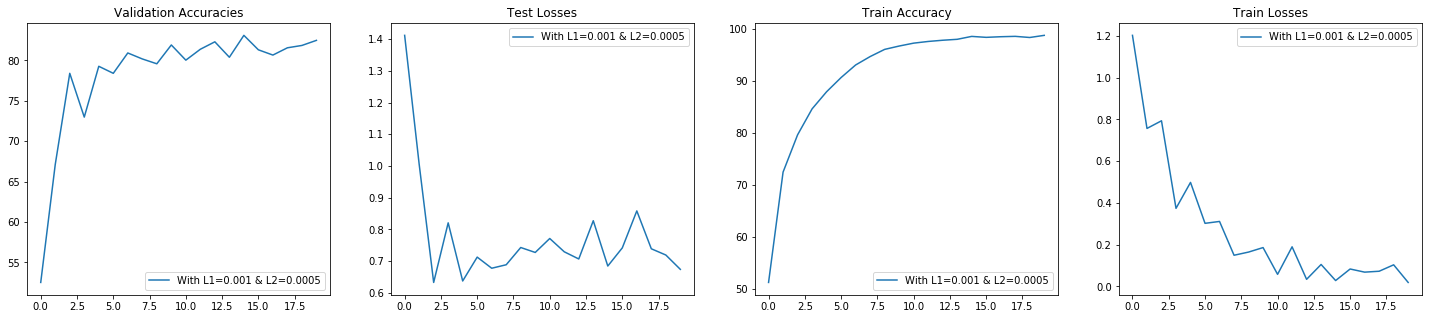

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Validation Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    

In [0]:
train_acc_all